<a href="https://colab.research.google.com/github/nahyeon-an/python/blob/main/ML/store-sales/baseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

시계열 예측  
매장 판매를 예측  
평가 : RMSE  

제출 파일 형태  
id,sales  
3000888,0.0  
3000889,0.0  
3000890,0.0  
3000891,0.0  
3000892,0.0  
etc.  

# Download Data

In [1]:
! pip install -q kaggle

In [2]:
from google.colab import files

In [3]:
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"nahyeon","key":"815b1dd2fe9debea6eed007e86c8fb86"}'}

In [4]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle competitions download -c store-sales-time-series-forecasting

 80% 17.0M/21.4M [00:00<00:00, 31.2MB/s]
100% 21.4M/21.4M [00:00<00:00, 33.3MB/s]


In [5]:
! mkdir sales
! unzip store-sales-time-series-forecasting.zip -d sales

Archive:  store-sales-time-series-forecasting.zip
  inflating: sales/holidays_events.csv  
  inflating: sales/oil.csv           
  inflating: sales/sample_submission.csv  
  inflating: sales/stores.csv        
  inflating: sales/test.csv          
  inflating: sales/train.csv         
  inflating: sales/transactions.csv  


# Import and Settings

In [6]:
# 데이터 경로
path = 'sales/{}'

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder

# EDA

## holidays_events.csv

In [8]:
df = pd.read_csv(path.format('holidays_events.csv'))

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 350 entries, 0 to 349
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   date         350 non-null    object
 1   type         350 non-null    object
 2   locale       350 non-null    object
 3   locale_name  350 non-null    object
 4   description  350 non-null    object
 5   transferred  350 non-null    bool  
dtypes: bool(1), object(5)
memory usage: 14.1+ KB


In [10]:
df.head()

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


### 시간 변환

In [16]:
df['year'] = pd.to_datetime(df['date'], format='%Y-%m-%d').dt.year
df['month'] = pd.to_datetime(df['date'], format='%Y-%m-%d').dt.month
df['day'] = pd.to_datetime(df['date'], format='%Y-%m-%d').dt.day

In [17]:
df.drop('date', axis=1, inplace=True)

In [18]:
df.head()

,type,locale,locale_name,description,transferred,year,month,day
0,Holiday,Local,Manta,Fundacion de Manta,False,2012,3,2
1,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False,2012,4,1
2,Holiday,Local,Cuenca,Fundacion de Cuenca,False,2012,4,12
3,Holiday,Local,Libertad,Cantonizacion de Libertad,False,2012,4,14
4,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False,2012,4,21


### type : 카테고리형 컬럼

In [19]:
df['type'].unique()

array(['Holiday', 'Transfer', 'Additional', 'Bridge', 'Work Day', 'Event'],
      dtype=object)

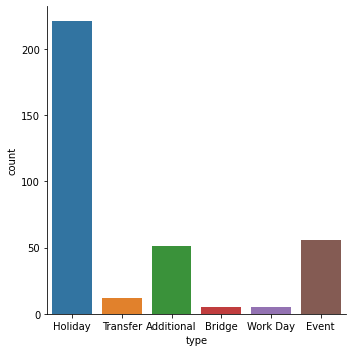

In [20]:
sns.catplot(data=df, x='type', kind='count')
plt.show()

In [23]:
le = LabelEncoder()
df['type'] = le.fit_transform(df['type'])

In [24]:
df.head()

,type,locale,locale_name,description,transferred,year,month,day
0,3,Local,Manta,Fundacion de Manta,False,2012,3,2
1,3,Regional,Cotopaxi,Provincializacion de Cotopaxi,False,2012,4,1
2,3,Local,Cuenca,Fundacion de Cuenca,False,2012,4,12
3,3,Local,Libertad,Cantonizacion de Libertad,False,2012,4,14
4,3,Local,Riobamba,Cantonizacion de Riobamba,False,2012,4,21


### locale : 카테고리형 컬럼

In [21]:
df['locale'].unique()

array(['Local', 'Regional', 'National'], dtype=object)

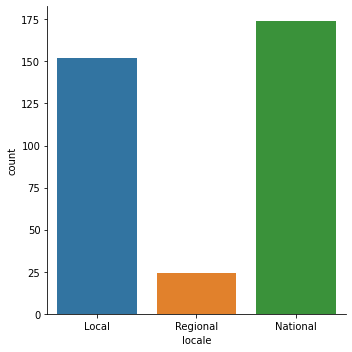

In [22]:
sns.catplot(data=df, x='locale', kind='count')
plt.show()

In [25]:
le = LabelEncoder()
df['locale'] = le.fit_transform(df['locale'])

In [26]:
df.head()

,type,locale,locale_name,description,transferred,year,month,day
0,3,0,Manta,Fundacion de Manta,False,2012,3,2
1,3,2,Cotopaxi,Provincializacion de Cotopaxi,False,2012,4,1
2,3,0,Cuenca,Fundacion de Cuenca,False,2012,4,12
3,3,0,Libertad,Cantonizacion de Libertad,False,2012,4,14
4,3,0,Riobamba,Cantonizacion de Riobamba,False,2012,4,21


### locale_name : 카테고리형 (카테고리 좀 많음)

In [27]:
le = LabelEncoder()
df['locale_name'] = le.fit_transform(df['locale_name'])

In [28]:
df.head()

,type,locale,locale_name,description,transferred,year,month,day
0,3,0,15,Fundacion de Manta,False,2012,3,2
1,3,2,2,Provincializacion de Cotopaxi,False,2012,4,1
2,3,0,3,Fundacion de Cuenca,False,2012,4,12
3,3,0,12,Cantonizacion de Libertad,False,2012,4,14
4,3,0,19,Cantonizacion de Riobamba,False,2012,4,21


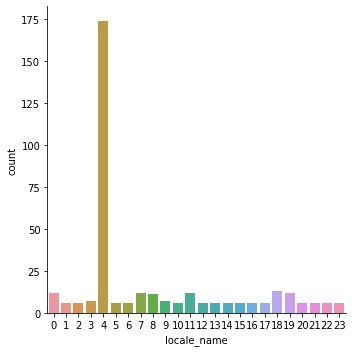

In [29]:
sns.catplot(data=df, x='locale_name', kind='count')
plt.show()

### description : 텍스트  

### transferred : boolean

### oil.csv

In [ ]:
df = pd.read_csv(path.format('oil.csv'))
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1218 entries, 0 to 1217
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   date        1218 non-null   object 
 1   dcoilwtico  1175 non-null   float64
dtypes: float64(1), object(1)
memory usage: 19.2+ KB


In [ ]:
df.head()

,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.14
2,2013-01-03,92.97
3,2013-01-04,93.12
4,2013-01-07,93.20


### stores.csv  
가게 정보  
도시, 주, 타입, 클러스터 번호  

In [ ]:
df = pd.read_csv(path.format('stores.csv'))
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54 entries, 0 to 53
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   store_nbr  54 non-null     int64 
 1   city       54 non-null     object
 2   state      54 non-null     object
 3   type       54 non-null     object
 4   cluster    54 non-null     int64 
dtypes: int64(2), object(3)
memory usage: 2.2+ KB


In [ ]:
df.head()

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


### transactions.csv

In [ ]:
df = pd.read_csv(path.format('transactions.csv'))
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83488 entries, 0 to 83487
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   date          83488 non-null  object
 1   store_nbr     83488 non-null  int64 
 2   transactions  83488 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 1.9+ MB


In [ ]:
df.head()

,date,store_nbr,transactions
0,2013-01-01,25,770
1,2013-01-02,1,2111
2,2013-01-02,2,2358
3,2013-01-02,3,3487
4,2013-01-02,4,1922


### train.csv

In [ ]:
train_df = pd.read_csv(path.format('train.csv'))
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 6 columns):
 #   Column       Dtype  
---  ------       -----  
 0   id           int64  
 1   date         object 
 2   store_nbr    int64  
 3   family       object 
 4   sales        float64
 5   onpromotion  int64  
dtypes: float64(1), int64(3), object(2)
memory usage: 137.4+ MB


In [ ]:
train_df.head()

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0


### test.csv

In [ ]:
test_df = pd.read_csv(path.format('test.csv'))
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28512 entries, 0 to 28511
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           28512 non-null  int64 
 1   date         28512 non-null  object
 2   store_nbr    28512 non-null  int64 
 3   family       28512 non-null  object
 4   onpromotion  28512 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 1.1+ MB


# Linear Regression

In [ ]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()

In [ ]:
X = train_df.loc[:, ['store_nbr', 'onpromotion']]
y = train_df.loc[:, 'sales']
model.fit(X, y)

LinearRegression()

In [ ]:
X_test = test_df.loc[:, ['store_nbr', 'onpromotion']]
y_pred = model.predict(X_test)

In [ ]:
baseline_df = pd.DataFrame(data={'id': test_df['id'], 'sales': y_pred})
baseline_df.to_csv('submission.csv', index=False)

In [ ]:
baseline_df

,id,sales
0,3000888,186.039818
1,3000889,186.039818
2,3000890,263.176932
3,3000891,957.410955
4,3000892,186.039818
...,...,...
28507,3029395,246.148251
28508,3029396,207.579694
28509,3029397,246.148251
28510,3029398,554.696706


In [ ]:
! kaggle competitions submit -c store-sales-time-series-forecasting -f submission.csv -m "Baseline Submission"

100% 736k/736k [00:01<00:00, 531kB/s]
Successfully submitted to Store Sales - Time Series Forecasting